# TransE Model Training

This notebook implements and trains the TransE (Translating Embeddings) model for citation link prediction. The model learns embeddings such that for each citation relationship (source_paper, target_paper), the embedding of source_paper + relation ≈ embedding of target_paper.

## Training Pipeline:
1. Load and prepare citation data
2. Create train/test splits with negative sampling
3. Initialize and configure TransE model
4. Train with margin ranking loss
5. Monitor training progress
6. Save trained model for evaluation

In [2]:
import sys
print(sys.executable)
!{sys.executable} -m pip install tqdm

/Users/bhs/PROJECTS/citation-map-dashboard/.venv/bin/python
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# Import required libraries
import sys
sys.path.append('..')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import our modules
from src.db import Neo4jConnection
from src.data_extraction import load_citation_graph
from src.model import create_model, TransE, TransETrainer
from src.visualization import plot_training_history, set_portfolio_style

# Set up environment
load_dotenv()
set_portfolio_style()

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("Libraries imported successfully!")

Using device: cpu
Libraries imported successfully!


## 1. Load Citation Network Data

In [4]:
# Connect to database and load data
print("Connecting to Neo4j and loading citation network...")

db = Neo4jConnection()
if not db.test_connection():
    raise ConnectionError("Failed to connect to Neo4j database")

# Load citation graph
extractor = load_citation_graph(db)

print(f"\nDataset loaded:")
print(f"• Papers: {extractor.num_entities:,}")
print(f"• Citations: {len(extractor.citation_edges):,}")
print(f"• Average citations per paper: {len(extractor.citation_edges) / extractor.num_entities:.2f}")

# Get network statistics for context
stats = extractor.get_dataset_stats()
print(f"• Network density: {stats['density']:.6f}")
print(f"• Average degree: {stats['avg_degree']:.2f}")

Connecting to Neo4j and loading citation network...
Extracting citation edges...
Extracting paper metadata...
Extracted 18912 citation edges between 12553 papers

Dataset loaded:
• Papers: 12,553
• Citations: 18,912
• Average citations per paper: 1.51
• Network density: 0.000120
• Average degree: 3.01


## 2. Prepare Training Data

In [5]:
# Create train/test splits with negative sampling
print("Creating training data with train/test split...")

# Parameters for data preparation
TEST_SIZE = 0.2         # 80/20 train/test split
NEGATIVE_RATIO = 1      # 1:1 ratio of negative to positive samples
RANDOM_STATE = 42       # For reproducible results

training_data = extractor.create_training_data(
    test_size=TEST_SIZE,
    negative_ratio=NEGATIVE_RATIO,
    random_state=RANDOM_STATE
)

print(f"\nTraining data prepared:")
print(f"• Train edges: {len(training_data['train_edges']):,}")
print(f"• Test edges: {len(training_data['test_edges']):,}")
print(f"• Train positive/negative ratio: 1:{NEGATIVE_RATIO}")
print(f"• Entity vocabulary size: {training_data['num_entities']:,}")

# Extract data for training
train_edges = training_data['train_edges']
train_labels = training_data['train_labels']
test_edges = training_data['test_edges']
test_labels = training_data['test_labels']
num_entities = training_data['num_entities']
entity_mapping = training_data['entity_mapping']

# Split positive and negative samples for training
train_pos_mask = train_labels == 1
train_neg_mask = train_labels == 0

train_pos_edges = train_edges[train_pos_mask]
train_neg_edges = train_edges[train_neg_mask]

print(f"\nSplit breakdown:")
print(f"• Training positive: {len(train_pos_edges):,}")
print(f"• Training negative: {len(train_neg_edges):,}")
print(f"• Test samples: {len(test_edges):,}")

Creating training data with train/test split...

Training data prepared:
• Train edges: 30,258
• Test edges: 7,566
• Train positive/negative ratio: 1:1
• Entity vocabulary size: 12,553

Split breakdown:
• Training positive: 15,129
• Training negative: 15,129
• Test samples: 7,566


## 3. Model Configuration and Initialization

In [6]:
# Model hyperparameters
EMBEDDING_DIM = 128     # Dimension of entity embeddings
MARGIN = 1.0           # Margin for ranking loss
LEARNING_RATE = 0.01   # Learning rate for Adam optimizer
P_NORM = 1             # L1 norm for TransE scoring (can be 1 or 2)

print("Model Configuration:")
print(f"• Embedding dimension: {EMBEDDING_DIM}")
print(f"• Margin: {MARGIN}")
print(f"• Learning rate: {LEARNING_RATE}")
print(f"• P-norm: {P_NORM}")
print(f"• Device: {device}")

# Create TransE model
print("\nInitializing TransE model...")
trainer = create_model(
    num_entities=num_entities,
    embedding_dim=EMBEDDING_DIM,
    margin=MARGIN,
    learning_rate=LEARNING_RATE,
    device=device
)

print(f"Model created with {num_entities:,} entities")
print(f"Total parameters: {sum(p.numel() for p in trainer.model.parameters()):,}")

# Display model architecture
print("\nModel Architecture:")
print(trainer.model)

Model Configuration:
• Embedding dimension: 128
• Margin: 1.0
• Learning rate: 0.01
• P-norm: 1
• Device: cpu

Initializing TransE model...
Model created with 12,553 entities
Total parameters: 1,606,912

Model Architecture:
TransE(
  (entity_embeddings): Embedding(12553, 128)
  (relation_embedding): Embedding(1, 128)
)


## 4. Training Configuration

In [7]:
# Training hyperparameters
EPOCHS = 100           # Number of training epochs
BATCH_SIZE = 1024      # Batch size for training
VERBOSE = True         # Show training progress

print("Training Configuration:")
print(f"• Epochs: {EPOCHS}")
print(f"• Batch size: {BATCH_SIZE}")
print(f"• Total training samples: {len(train_pos_edges):,}")
print(f"• Batches per epoch: {(len(train_pos_edges) + BATCH_SIZE - 1) // BATCH_SIZE}")
print(f"• Estimated training time: ~{EPOCHS * len(train_pos_edges) // (BATCH_SIZE * 1000)} minutes")

# Move training data to device
print("\nMoving data to device...")
train_pos_edges = train_pos_edges.to(device)
train_neg_edges = train_neg_edges.to(device)

print("Ready to start training!")

Training Configuration:
• Epochs: 100
• Batch size: 1024
• Total training samples: 15,129
• Batches per epoch: 15
• Estimated training time: ~1 minutes

Moving data to device...
Ready to start training!


## 5. Model Training

In [8]:
# Train the model
print("Starting TransE model training...")
print("=" * 50)

training_history = trainer.train(
    positive_edges=train_pos_edges,
    negative_edges=train_neg_edges,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE
)

print("\n" + "=" * 50)
print("Training completed!")
print(f"Final training loss: {training_history['loss'][-1]:.4f}")
print(f"Loss reduction: {training_history['loss'][0]:.4f} → {training_history['loss'][-1]:.4f}")
print(f"Improvement: {((training_history['loss'][0] - training_history['loss'][-1]) / training_history['loss'][0] * 100):.1f}%")

Starting TransE model training...


Training TransE: 100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.44it/s, Loss=0.0000]


Training completed!
Final training loss: 0.0000
Loss reduction: 0.2636 → 0.0000
Improvement: 100.0%


## 6. Training Progress Visualization

Visualizing training progress...


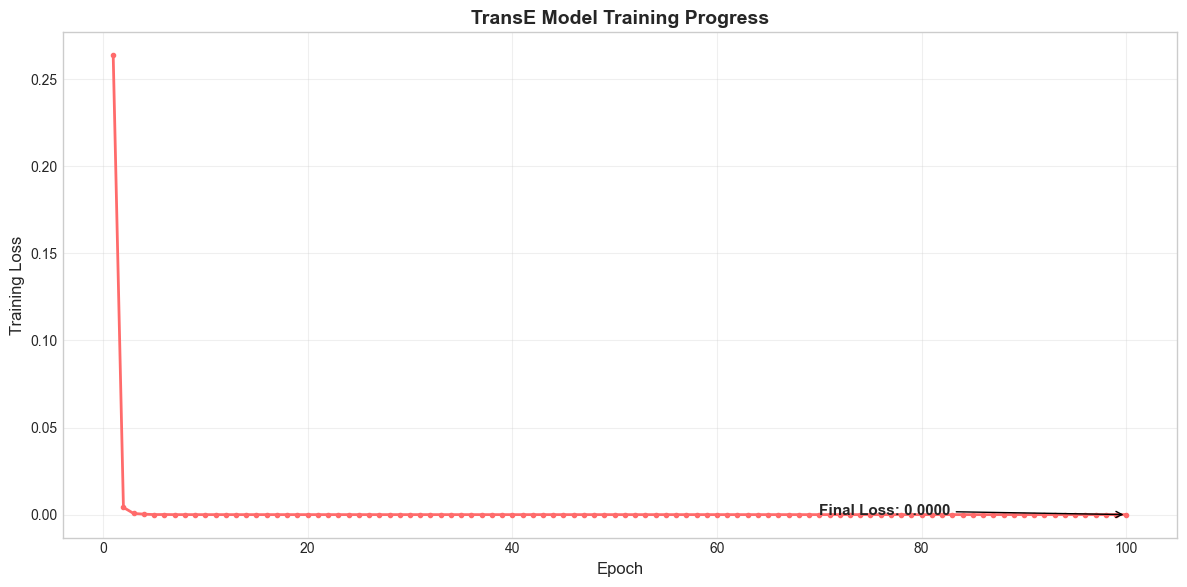


📊 Training Statistics:
• Total epochs: 100
• Initial loss: 0.2636
• Final loss: 0.0000
• Best loss: 0.0000
• Loss variance: 0.000000 (last 10 epochs)
✅ Model appears to have converged (stable recent loss)


In [9]:
# Plot training loss history
print("Visualizing training progress...")

fig = plot_training_history(
    training_history['loss'],
    figsize=(12, 6),
    save_path="../outputs/training_history.png"
)
plt.show()

# Additional training statistics
print("\n📊 Training Statistics:")
print(f"• Total epochs: {len(training_history['loss'])}")
print(f"• Initial loss: {training_history['loss'][0]:.4f}")
print(f"• Final loss: {training_history['loss'][-1]:.4f}")
print(f"• Best loss: {min(training_history['loss']):.4f}")
print(f"• Loss variance: {np.var(training_history['loss'][-10:]):.6f} (last 10 epochs)")

# Check convergence
recent_losses = training_history['loss'][-20:] if len(training_history['loss']) >= 20 else training_history['loss']
loss_std = np.std(recent_losses)
if loss_std < 0.01:
    print("✅ Model appears to have converged (stable recent loss)")
else:
    print("⚠️  Model may benefit from additional training epochs")

## 7. Model Inspection

In [10]:
# Inspect learned embeddings
print("Inspecting learned embeddings...")

# Get entity embeddings
with torch.no_grad():
    entity_embeddings = trainer.model.entity_embeddings.weight.cpu()
    relation_embedding = trainer.model.relation_embedding.weight.cpu()

print(f"\n📐 Embedding Properties:")
print(f"• Entity embeddings shape: {entity_embeddings.shape}")
print(f"• Relation embedding shape: {relation_embedding.shape}")
print(f"• Entity embedding norm (mean): {torch.norm(entity_embeddings, dim=1).mean():.4f}")
print(f"• Entity embedding norm (std): {torch.norm(entity_embeddings, dim=1).std():.4f}")
print(f"• Relation embedding norm: {torch.norm(relation_embedding).item():.4f}")

# Analyze embedding distribution
embedding_stats = {
    'mean': entity_embeddings.mean().item(),
    'std': entity_embeddings.std().item(),
    'min': entity_embeddings.min().item(),
    'max': entity_embeddings.max().item()
}

print(f"\n📈 Embedding Value Distribution:")
for stat, value in embedding_stats.items():
    print(f"• {stat.capitalize()}: {value:.4f}")

Inspecting learned embeddings...

📐 Embedding Properties:
• Entity embeddings shape: torch.Size([12553, 128])
• Relation embedding shape: torch.Size([1, 128])
• Entity embedding norm (mean): 1.0000
• Entity embedding norm (std): 0.0000
• Relation embedding norm: 1.8063

📈 Embedding Value Distribution:
• Mean: -0.0005
• Std: 0.0884
• Min: -0.3031
• Max: 0.3213


## 8. Quick Training Validation

In [11]:
# Quick validation on training data
print("Performing quick training validation...")

trainer.model.eval()
with torch.no_grad():
    # Sample some training examples
    sample_size = min(1000, len(train_pos_edges))
    sample_indices = torch.randperm(len(train_pos_edges))[:sample_size]
    
    sample_pos = train_pos_edges[sample_indices]
    sample_neg = train_neg_edges[sample_indices]
    
    # Get scores (lower = more likely)
    pos_scores = trainer.model(sample_pos[:, 0], sample_pos[:, 1])
    neg_scores = trainer.model(sample_neg[:, 0], sample_neg[:, 1])
    
    # Calculate metrics
    pos_mean = pos_scores.mean().item()
    neg_mean = neg_scores.mean().item()
    
    print(f"\n🎯 Training Sample Validation ({sample_size} samples):")
    print(f"• Average positive score: {pos_mean:.4f}")
    print(f"• Average negative score: {neg_mean:.4f}")
    print(f"• Score separation: {neg_mean - pos_mean:.4f}")
    
    if neg_mean > pos_mean:
        print("✅ Model correctly assigns lower scores to positive samples")
        separation_quality = "Good" if (neg_mean - pos_mean) > 0.5 else "Moderate"
        print(f"• Separation quality: {separation_quality}")
    else:
        print("⚠️  Model may need more training - negative samples have lower scores")

Performing quick training validation...

🎯 Training Sample Validation (1000 samples):
• Average positive score: 14.0030
• Average negative score: 22.3366
• Score separation: 8.3336
✅ Model correctly assigns lower scores to positive samples
• Separation quality: Good


## 9. Save Trained Model

In [12]:
# Save the trained model
model_path = "../models/transe_citation_model.pt"
print(f"Saving trained model to {model_path}...")

trainer.save_model(model_path)

# Also save entity mapping for later use
import pickle
mapping_path = "../models/entity_mapping.pkl"
with open(mapping_path, 'wb') as f:
    pickle.dump(entity_mapping, f)

# Save training metadata
metadata = {
    'num_entities': num_entities,
    'num_train_edges': len(train_edges),
    'num_test_edges': len(test_edges),
    'embedding_dim': EMBEDDING_DIM,
    'margin': MARGIN,
    'learning_rate': LEARNING_RATE,
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'final_loss': training_history['loss'][-1],
    'device': str(device)
}

metadata_path = "../models/training_metadata.pkl"
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)

print(f"\n💾 Files saved:")
print(f"• Model: {model_path}")
print(f"• Entity mapping: {mapping_path}")
print(f"• Training metadata: {metadata_path}")
print(f"• Training plot: ../outputs/training_history.png")

Saving trained model to ../models/transe_citation_model.pt...

💾 Files saved:
• Model: ../models/transe_citation_model.pt
• Entity mapping: ../models/entity_mapping.pkl
• Training metadata: ../models/training_metadata.pkl
• Training plot: ../outputs/training_history.png


## 10. Training Summary

In [13]:
# Comprehensive training summary
print("\n" + "="*60)
print("🎓 TRAINING SUMMARY")
print("="*60)

print(f"\n📊 Dataset:")
print(f"   • {num_entities:,} papers (entities)")
print(f"   • {len(extractor.citation_edges):,} citation relationships")
print(f"   • {len(train_edges):,} training examples ({len(train_pos_edges):,} pos, {len(train_neg_edges):,} neg)")
print(f"   • {len(test_edges):,} test examples")

print(f"\n🧠 Model Architecture:")
print(f"   • TransE with {EMBEDDING_DIM}-dimensional embeddings")
print(f"   • {sum(p.numel() for p in trainer.model.parameters()):,} total parameters")
print(f"   • Margin ranking loss with margin = {MARGIN}")
print(f"   • L{P_NORM} norm for distance computation")

print(f"\n⚙️  Training Configuration:")
print(f"   • {EPOCHS} epochs with batch size {BATCH_SIZE}")
print(f"   • Adam optimizer with learning rate {LEARNING_RATE}")
print(f"   • Trained on {device}")

print(f"\n📈 Results:")
print(f"   • Final loss: {training_history['loss'][-1]:.4f}")
print(f"   • Loss improvement: {((training_history['loss'][0] - training_history['loss'][-1]) / training_history['loss'][0] * 100):.1f}%")
print(f"   • Training converged: {'Yes' if loss_std < 0.01 else 'Potentially needs more epochs'}")

print(f"\n🎯 Next Steps:")
print(f"   • Run notebook 03_prediction_analysis.ipynb for comprehensive evaluation")
print(f"   • Evaluate with MRR, Hits@K, and AUC metrics")
print(f"   • Generate missing citation predictions")
print(f"   • Create story visualizations")

print("\n✅ Model training complete! Ready for evaluation.")


🎓 TRAINING SUMMARY

📊 Dataset:
   • 12,553 papers (entities)
   • 18,912 citation relationships
   • 30,258 training examples (15,129 pos, 15,129 neg)
   • 7,566 test examples

🧠 Model Architecture:
   • TransE with 128-dimensional embeddings
   • 1,606,912 total parameters
   • Margin ranking loss with margin = 1.0
   • L1 norm for distance computation

⚙️  Training Configuration:
   • 100 epochs with batch size 1024
   • Adam optimizer with learning rate 0.01
   • Trained on cpu

📈 Results:
   • Final loss: 0.0000
   • Loss improvement: 100.0%
   • Training converged: Yes

🎯 Next Steps:
   • Run notebook 03_prediction_analysis.ipynb for comprehensive evaluation
   • Evaluate with MRR, Hits@K, and AUC metrics
   • Generate missing citation predictions
   • Create story visualizations

✅ Model training complete! Ready for evaluation.


In [14]:
# Clean up
db.close()
print("Database connection closed.")

# Clear GPU memory if using CUDA
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print("GPU memory cleared.")

Database connection closed.
